# 1. Data Import and Overview
## Import data & packages

In [17]:
# 1 - Import all packages
import IPython
import pandas as pd
import matplotlib.pyplot as plt
import os
from qiime2 import Visualization

%matplotlib inline

In [2]:
# 2 - Set working directory
#os.chdir("/home/jovyan/MicrobiomeAnalysis_TummyTribe/")

# Verify that your wroking directory is the overall project folder (.../MicrobiomeAnalysis_TummyTribe)
print("Current working directory:", os.getcwd())

Current working directory: /home/jovyan/MicrobiomeAnalysis_TummyTribe/scripts


In [3]:
# 3 - Data directory for the raw data
data_dir = "../data/raw"

In [4]:
%%bash -s "$data_dir"
mkdir -p "$1"  # Make sure folder exists
cd "$1"

# 4 - Download files into the folder
wget -O metadata.tsv "https://polybox.ethz.ch/index.php/s/aNpBCyFwxfSfEFq/download"
wget --progress=bar:force:noscroll -O sequences-demux-paired.qza "https://polybox.ethz.ch/index.php/s/f4XQxriGrKqBcsm/download"


--2025-10-14 22:18:03--  https://polybox.ethz.ch/index.php/s/aNpBCyFwxfSfEFq/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20838 (20K) [application/octet-stream]
Saving to: ‘metadata.tsv’

     0K .......... ..........                                 100% 14.6M=0.001s

2025-10-14 22:18:03 (14.6 MB/s) - ‘metadata.tsv’ saved [20838/20838]

--2025-10-14 22:18:03--  https://polybox.ethz.ch/index.php/s/f4XQxriGrKqBcsm/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4036859939 (3.8G) [application/octet-stream]
Saving to: ‘sequences-demux-paired.qza’

sequences-demux-pai 100%[===================>]   3.76G   236MB/s    in 14s     

2025-10-14 22:18:17 (278 MB/s) - ‘sequences-de

## Exploratory Data Analysis
### Metadata

In [5]:
# 5- Load the metadata as a pandas data frame & have a look at it
meta = pd.read_csv(f"{data_dir}/metadata.tsv", sep="\t")
print("First few rows of the metadata: \n", meta.head(), "\n")
print(f"Metadata has {meta.shape[0]} rows and {meta.shape[1]} comlumns.\n")

First few rows of the metadata: 
            id  host_id  age_months geo_location_name delivery_mode     sex  \
0  SRR8118533  E000823         4.0           Finland       vaginal    male   
1  SRR8118537  E000823         7.0           Finland       vaginal    male   
2  SRR8118564  E001958         4.0           Finland       vaginal  female   
3  SRR8118650  E001958         7.0           Finland       vaginal  female   
4  SRR8118652  E001958        10.0           Finland       vaginal  female   

  diet_weaning diet_milk  treatment_exposure  
0           no        bd               False  
1          yes     mixed               False  
2          yes        bd               False  
3          yes     mixed               False  
4          yes     mixed               False   

Metadata has 357 rows and 9 comlumns.



#### Missing data

In [6]:
# 6 - Compute the number of missing values for each column as counts and as percentage
missing_df = pd.DataFrame({
    'count': meta.isna().sum(),
    'percentage': round((meta.isna().sum() / len(meta)) * 100,1)})
print("Number of missing values for each column:")  
print(missing_df)

Number of missing values for each column:
                    count  percentage
id                      0         0.0
host_id                 0         0.0
age_months              0         0.0
geo_location_name       0         0.0
delivery_mode           0         0.0
sex                     0         0.0
diet_weaning           23         6.4
diet_milk              87        24.4
treatment_exposure      0         0.0


Except for the diet-related columns, there are no missing values in the meta data.
#### Overview of Metadata Distributions

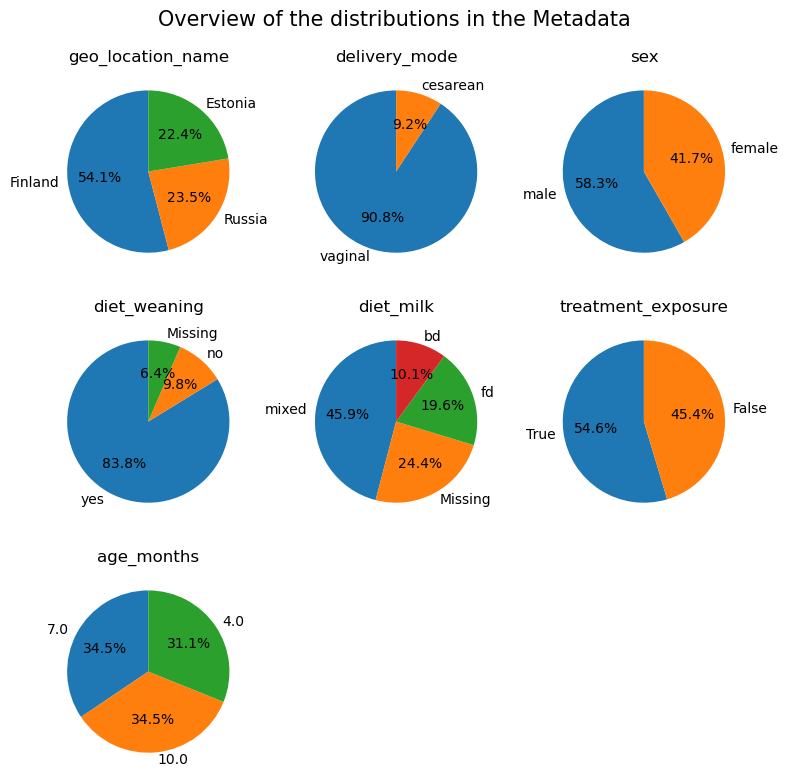

In [7]:
# 7 - Plot pie charts that show the relative frequencies of each category and any missing values
cat_col = ['geo_location_name', 'delivery_mode', 'sex', 'diet_weaning', 'diet_milk', 'treatment_exposure', 'age_months']

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten() # so you can enumerate them
fig.suptitle('Overview of the distributions in the Metadata', fontsize=15)

for i, col in enumerate(cat_col):
    # Include missing values as a separate category
    counts = meta[col].value_counts(dropna=False)
    counts.index = counts.index.fillna('Missing')
    # Create pie chart for each column
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(col)

# Since its an uneven number, hide the last subplot boxes
for j in range(len(cat_col), len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()


In [9]:
#number of children
len(pd.unique(meta["host_id"]))

190

In [12]:
#treatment exposure
samples_with_treatment = meta[meta["treatment_exposure"] == True]
len(pd.unique(samples_with_treatment["host_id"]))

104

The dataset contains 357 samples from 190 children. Samples were taken at 4, 7 and 10 months. The children are from Finland, Russia and Estonia. And the diet is either breast milk, formula or a mix of the two. 104 children were exposed to a treatment.

### Sequence data

In [13]:
# 8 - Have a look at the QIIME 2 artifact of the sequencing data
! qiime tools peek $data_dir/sequences-demux-paired.qza

UUID:        b4782ab7-550b-41f5-b906-ca2cda29ca9b
Type:        SampleData[PairedEndSequencesWithQuality]
Data format: SingleLanePerSamplePairedEndFastqDirFmt


In [14]:
! qiime demux summarize \
    --i-data $data_dir/sequences-demux-paired.qza \
    --o-visualization $data_dir/sequences-demux-paired.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: ../data/raw/sequences-demux-paired.qzv


In [18]:
Visualization.load(f"{data_dir}/sequences-demux-paired.qzv")

<visualization: Visualization uuid: 1b24bb88-d907-4131-8aa3-8b6e2dc2d0f8>